# Struc-mon 

In [1]:
from datetime import datetime, timedelta, date
import os

## Config
Contains file paths, sensor id:s, date formats, etc.
Make sure the path is pointing to the folder containing the Struc-mon repo.

In [2]:
import config

print(config.dir_path)

/home/jesper/Skrivbord/IoTBridge/struc-mon


### Create a settings object

In [3]:
from dataclasses import dataclass, field
@dataclass()
class Settings:
    sensors : list = field(default_factory=lambda:['acc1','incl'])
    start_date : str = '2021-05-04'
    end_date : str = '2021-05-05'
    normalization : str = 'mean' # mean or min-max
settings = Settings()

### Create a connection object

In [4]:
from SQLAConnection import SQLAConnection 
connection = SQLAConnection()

### Create a query generator

In [5]:
from QueryGenerator import QueryGenerator
query_generator = QueryGenerator(
    settings.sensors,settings.start_date,settings.end_date)

# Get Data
There are two methods to choose from. 

## Method 1: Acquire data via SQL
Establish a connection to a Server and generate an SQL-query. 

### Fetch data

In [6]:
from AnomalyData import AnomalyData
data = AnomalyData(query_generator,connection)

In [7]:
data.make_df()
print(data.df.head())

   acc1_ch_x  acc1_ch_y  acc1_ch_z  incl_ch_x  incl_ch_y  \
0    0.07867    0.37425    0.92277  -0.799576    17.8030   
1    0.07829    0.37387    0.92239  -0.802309    17.8071   
2    0.07875    0.37532    0.92330  -0.802855    17.8059   
3    0.07860    0.37479    0.92315  -0.803948    17.7985   
4    0.07890    0.37510    0.92307  -0.802855    17.7979   

                          ts  
0 2021-05-04 00:00:00.000000  
1 2021-05-04 00:00:00.030303  
2 2021-05-04 00:00:00.060606  
3 2021-05-04 00:00:00.515152  
4 2021-05-04 00:00:00.545455  


### Split df into smaller dfs for each date

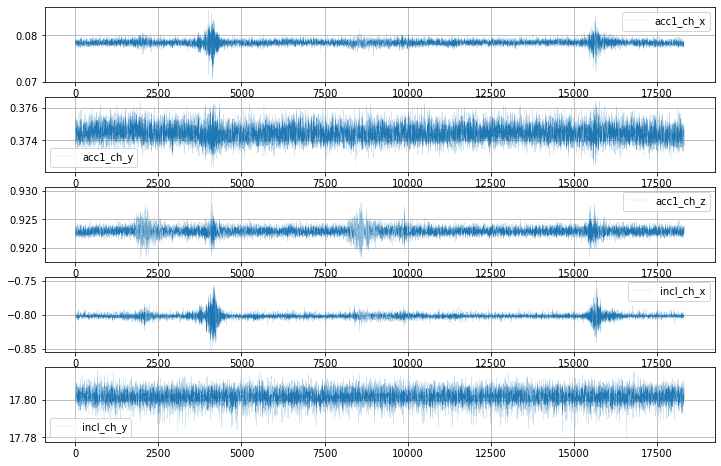

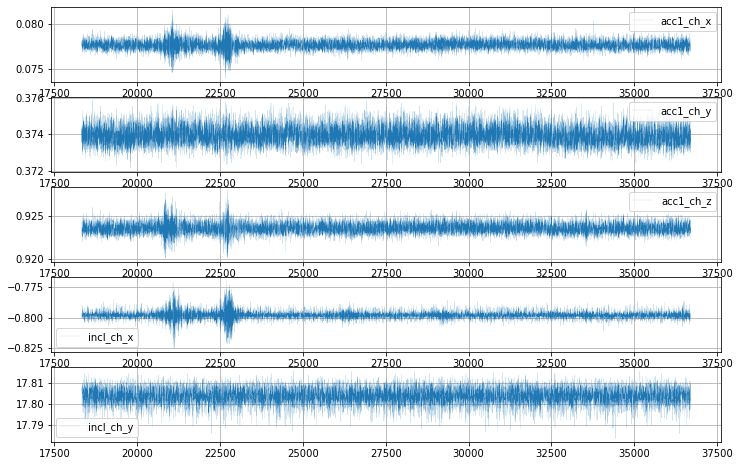

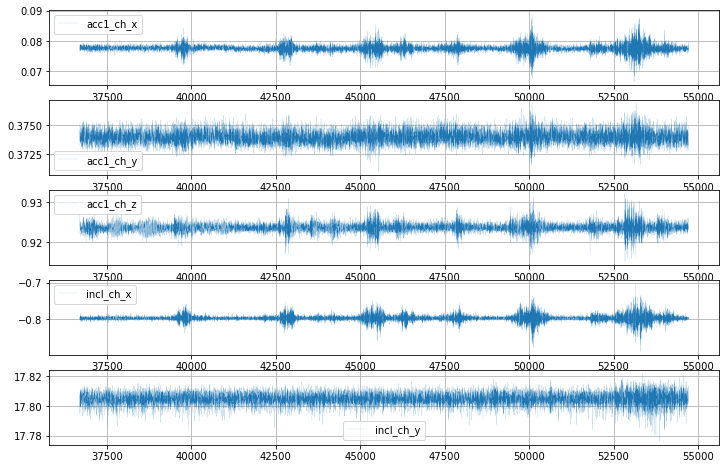

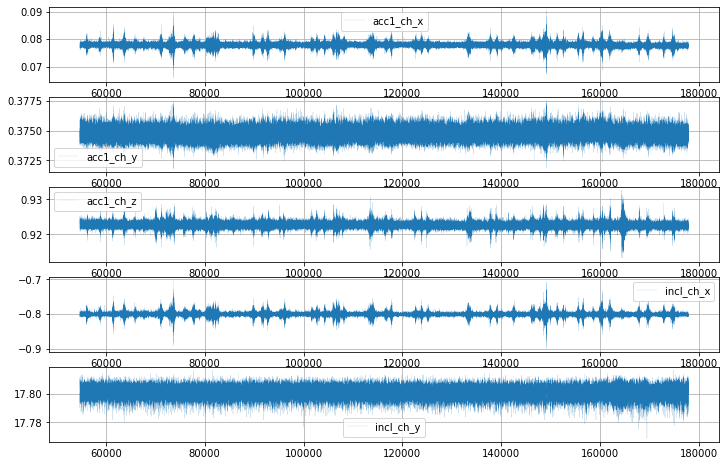

In [8]:
data.find_discontinuities()
data.split_at_discontinuities()
data.plot_data()

### Preprocess data
Method specified in settings. Y-axis is now shifted

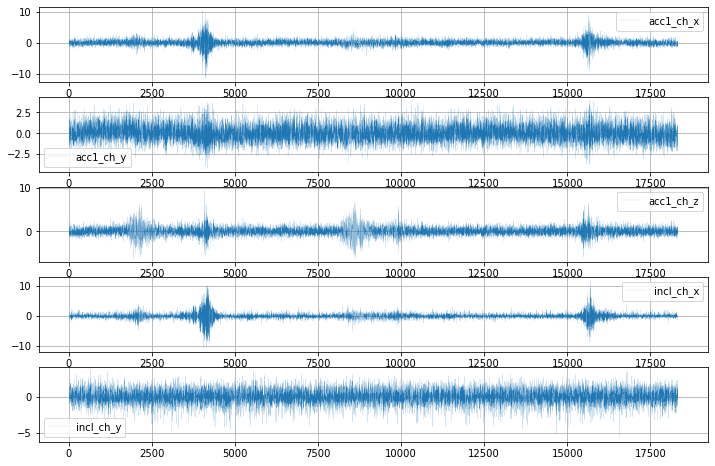

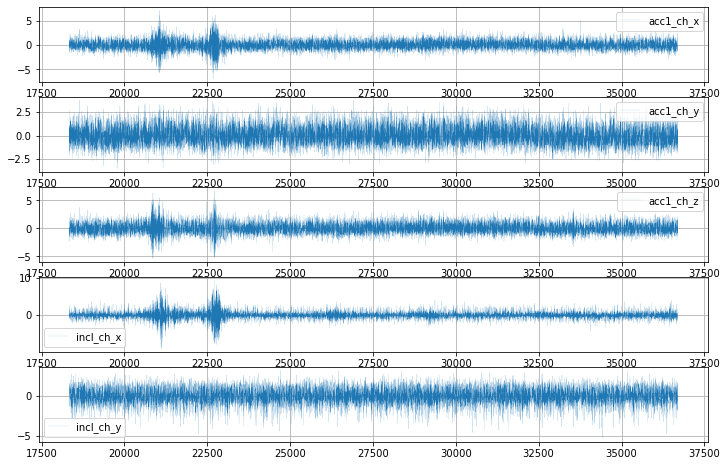

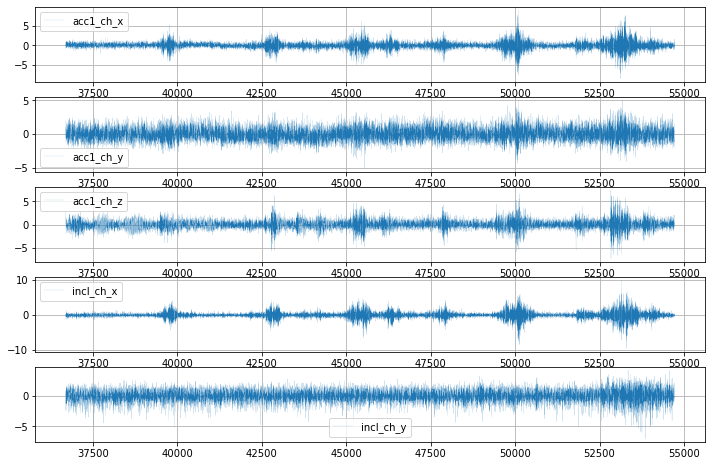

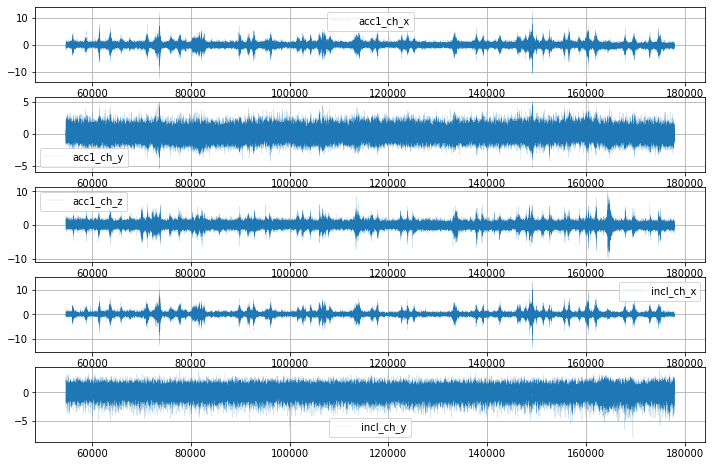

In [9]:
data.preprocess()
data.plot_data()

## Method 2: Load preexisting dfs
Mode `for` starts at `startdate` and uses `dates_ahead` to decide the last date to include.
Mode `while` starts at `startdate` and uses all available dates after. 

In [10]:
startdate = datetime.strptime('2020-11-01',config.dateformat)
data.load_dfs(date=datetime.strftime(startdate,config.dateformat))
dates_ahead = 4
mode = 'while'
if mode == 'for':
    for i in range(dates_ahead):

        data.load_extend_dfs(date=datetime.strftime(startdate+timedelta(days=i), config.dateformat))

elif mode == 'while': 
    tdate = startdate      
    while tdate.date() != date.today():
        try:
            data.load_extend_dfs(date=datetime.strftime(tdate, config.dateformat))

        except FileNotFoundError:
            pass
        tdate = tdate+timedelta(days=1)
data.purge_empty_dfs()  
data.preprocess()

## Filter hours
Keep only the hours within the specified time interval. 

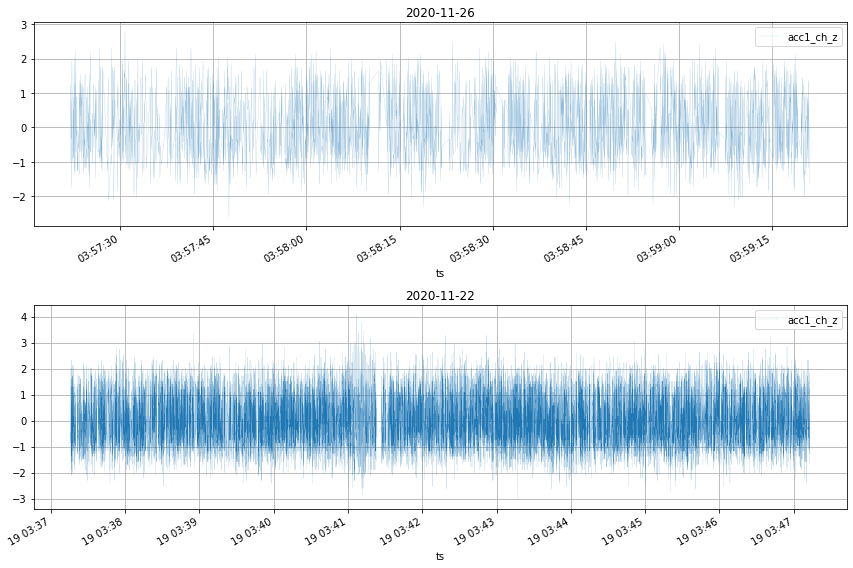

In [11]:
start_hour = '00:00:00'
end_hour = '23:59:59'
data.filter_hours(start_hour,end_hour)
data.purge_empty_time_filtered_dfs()
data.plot_filtered_hours(plot_objects=False)

### Correlation matrix 
Calculate the statistical correlation between the signals.

In [12]:
data.find_correlation()

           acc1_ch_x  acc1_ch_y  acc1_ch_z  incl_ch_x  incl_ch_y
acc1_ch_x   1.000000   0.115564   0.132920   0.298976  -0.038651
acc1_ch_y   0.115564   1.000000   0.253281  -0.206391  -0.150175
acc1_ch_z   0.132920   0.253281   1.000000   0.078200   0.108675
incl_ch_x   0.298976  -0.206391   0.078200   1.000000   0.055209
incl_ch_y  -0.038651  -0.150175   0.108675   0.055209   1.000000


### Anomaly objects
I.e. the segments where the data deviates from the baseline. 


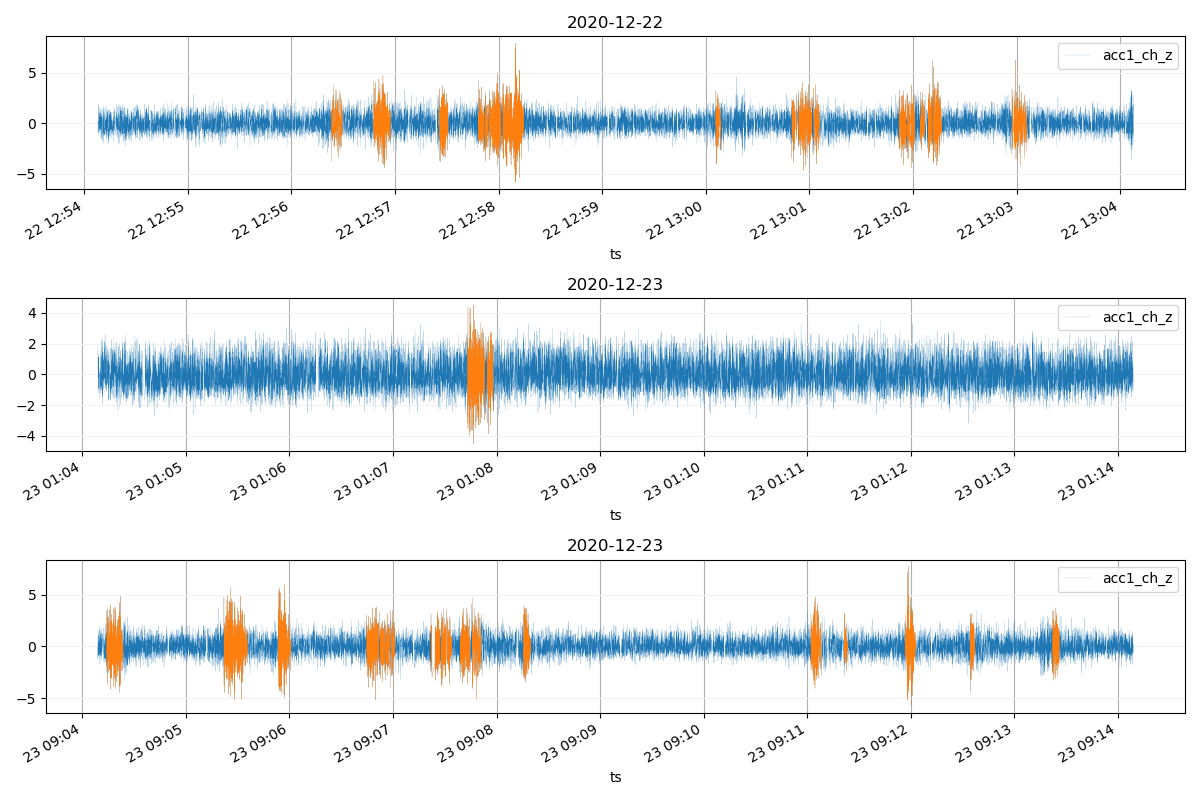

In [13]:
from IPython.display import Image
Image(f"{config.example_plot_path}anomalies.png")

### TBI Regularity objects
I.e. baseline segments

In [14]:
#TBI

### Define anomaly settings
Once a the absolute value of a signal is greather than the `threshold` it is considered to be an anomaly. 
The anomaly lasts at leasts for the amount of timesteps `patience` defines. If the threshold value is surpassed again before the patience is out the patience is restored.
`anomaly_sensor` defines which sensor(s) to run the anomaly algorithm on. 
Signals above `max_filter` are removed since they most likely are caused by faulty sensor readings. 

In [15]:
@dataclass 
class AnomalySettings():
    patience : int = 50
    threshold : int = 3
    anomaly_sensor : list = field(default_factory=lambda:['acc1_ch_x','incl_ch_x'])
    max_filter : int = 12
anomaly_settings = AnomalySettings()

### Either load existing anomaly objects or generate new ones


In [16]:
data.set_object_settings(anomaly_settings)
anomaly_name = f"{startdate}_{mode}_{start_hour}_{end_hour}_{anomaly_settings.anomaly_sensor}_anomaly"
if f"{anomaly_name}.json" in os.listdir(config.anomaly_path):
    data.load_objects(name=f"{anomaly_name}")
    print(f"{anomaly_name} loaded")
else:       
    for feature in anomaly_settings.anomaly_sensor:
        data.locate_objects_dfs(feature)
    data.save_objects(name=anomaly_name)

2020-11-01 00:00:00_while_00:00:00_23:59:59_['acc1_ch_x', 'incl_ch_x']_anomaly loaded


### Plot examples of anomalies

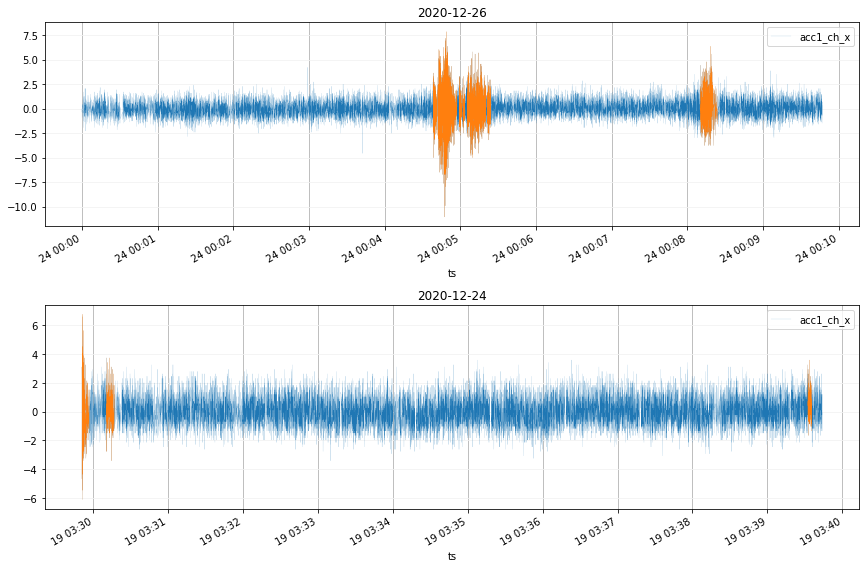

In [17]:
data.plot_filtered_hours(foi = 'acc1_ch_x')

## PCA
Initiate a pca-model. Data matrix `X`'s columns are specified by `features`. `n_components` defines the fraction of the total explained variance to be covered by the components. 

In [18]:
from PCAAnomalies import PCAAnomalies
features = ['duration','mu','abs_mu','sigma',
           'max_a','rms','frequency']
n_components = 0.99
pca = PCAAnomalies(data.objects,settings,
                   features = features,n_components = 0.99)

Fit the PCA model using the anomaly/ regularity objects.
Display the scree plot to show the fraction of the total variance explained by each component. 

Dimension of X: 147231
Explained variance ratio: [0.89808539 0.07053303 0.01608387 0.01256096]
Singular values: [85.68234992 24.01202629 11.46642069 10.13314014]


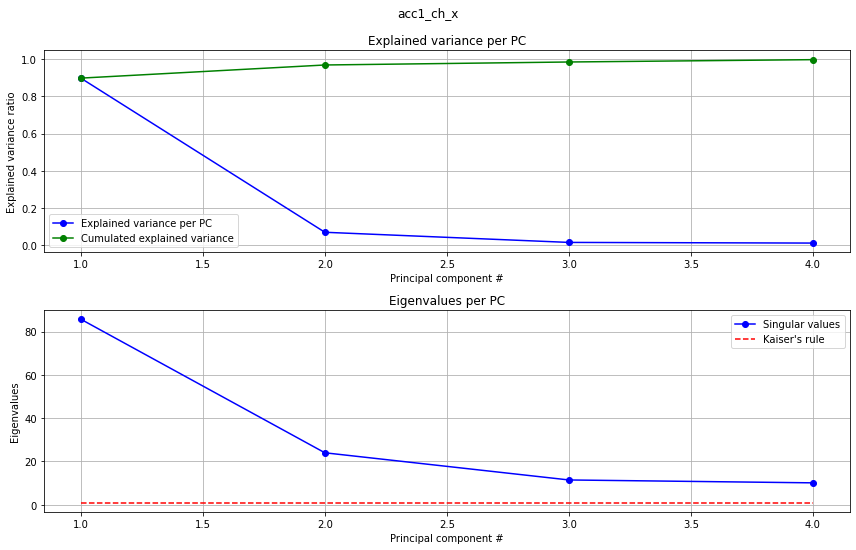

In [19]:
pca.fit_PCA()
pca.scree_plot()

### PCA components
Plot the componens and color the according to `features`. 

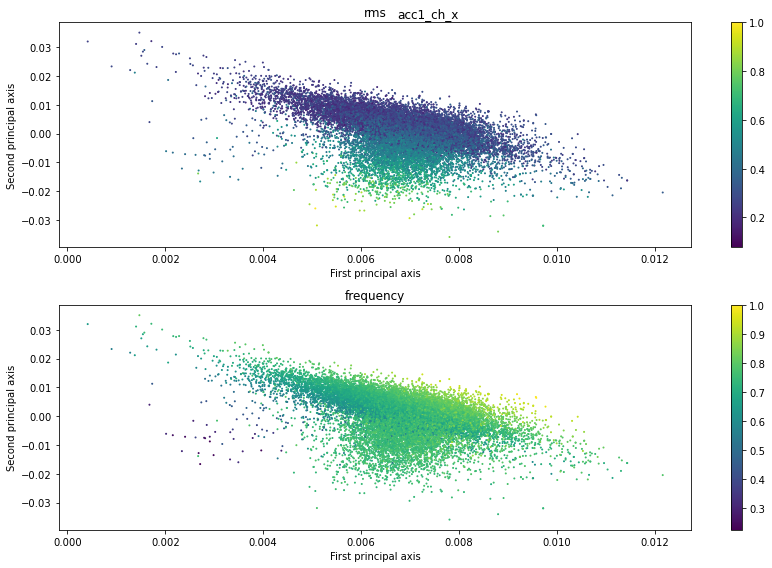

In [20]:
pca.plot_components(features = ['rms','frequency'])

## Kmeans classification

In [21]:
@dataclass 
class KMeansSettings():
    n_clusters : int = 3
    init : str = 'k-means++'
    n_init : int = 5
    max_iter : int = 300
    tol : float = 1e-4    
    verbose : int = 0
kmeans_settings = KMeansSettings()

In [22]:
from KMeansClustering import KMeansClustering
kmeans = KMeansClustering(data.objects,kmeans_settings,features)

### Fit Kmeans

In [23]:
kmeans.fit_Kmeans()

### Plot Kmeans categories on top of PCA

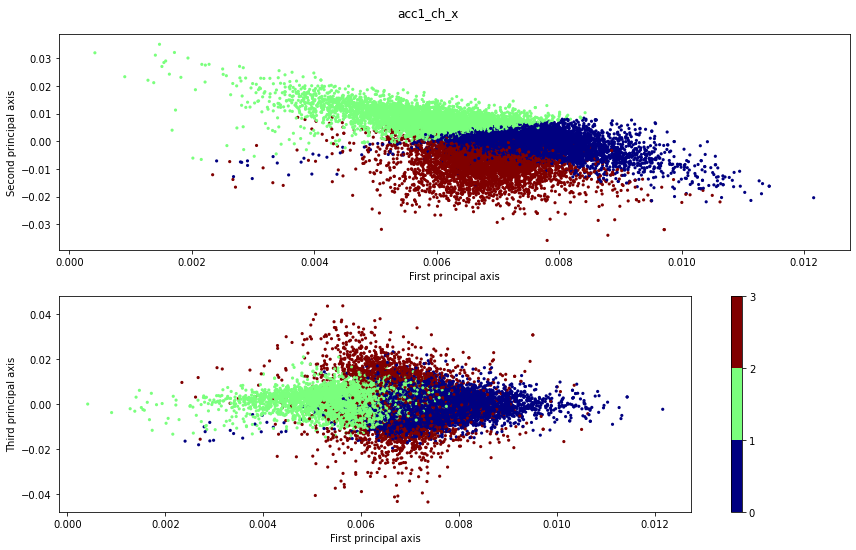

In [24]:
pca.set_labels(kmeans.send_labels())
pca.plot_components_labels(n_categories = kmeans_settings.n_clusters)

### Plot Kmeans categories on top of PCA and encirculate in-person observations

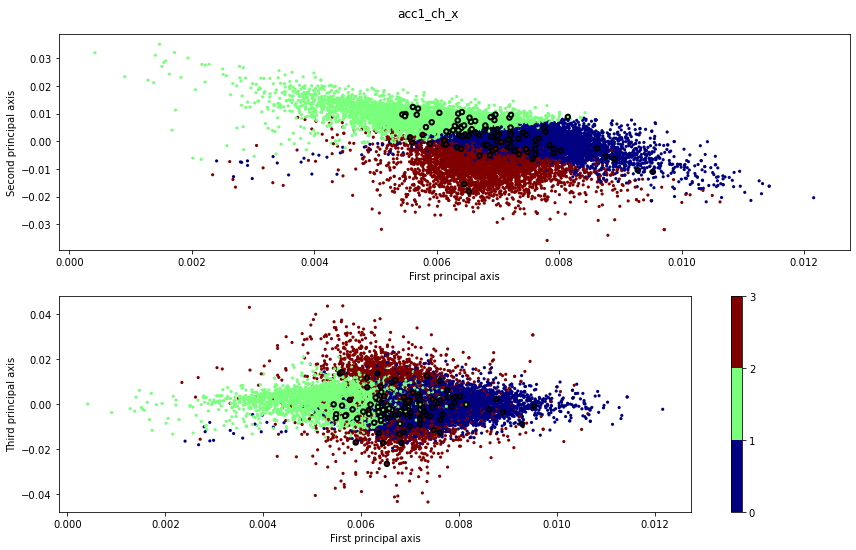

In [25]:
pca.plot_components_labels(n_categories = kmeans_settings.n_clusters,plot_irl_observation=True)

### Histogram of samples per category per PCA component

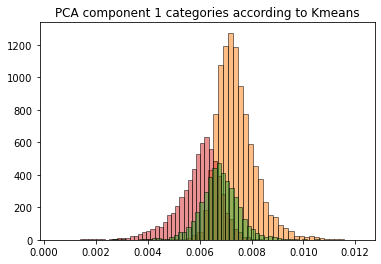

In [26]:
pca.plot_hist_pca(component = 1)

{21033: 
anomaly duration: 0.294, anomaly average: 2.343, 21034: 
anomaly duration: 0.051, anomaly average: 1.193, 21035: 
anomaly duration: 0.115, anomaly average: 1.183, 21036: 
anomaly duration: 0.073, anomaly average: 1.376, 21037: 
anomaly duration: 0.107, anomaly average: 1.546, 21038: 
anomaly duration: 0.060, anomaly average: 1.240, 21039: 
anomaly duration: 0.398, anomaly average: 1.837, 21040: 
anomaly duration: 0.094, anomaly average: 1.254, 21041: 
anomaly duration: 0.161, anomaly average: 1.524, 21042: 
anomaly duration: 0.050, anomaly average: 0.917, 21043: 
anomaly duration: 0.124, anomaly average: 1.534, 21044: 
anomaly duration: 0.093, anomaly average: 1.115, 21045: 
anomaly duration: 0.396, anomaly average: 1.498, 21046: 
anomaly duration: 0.129, anomaly average: 1.647}
{21033: 
anomaly duration: 0.070, anomaly average: 1.092, 21034: 
anomaly duration: 0.093, anomaly average: 1.216, 21035: 
anomaly duration: 0.376, anomaly average: 2.212}


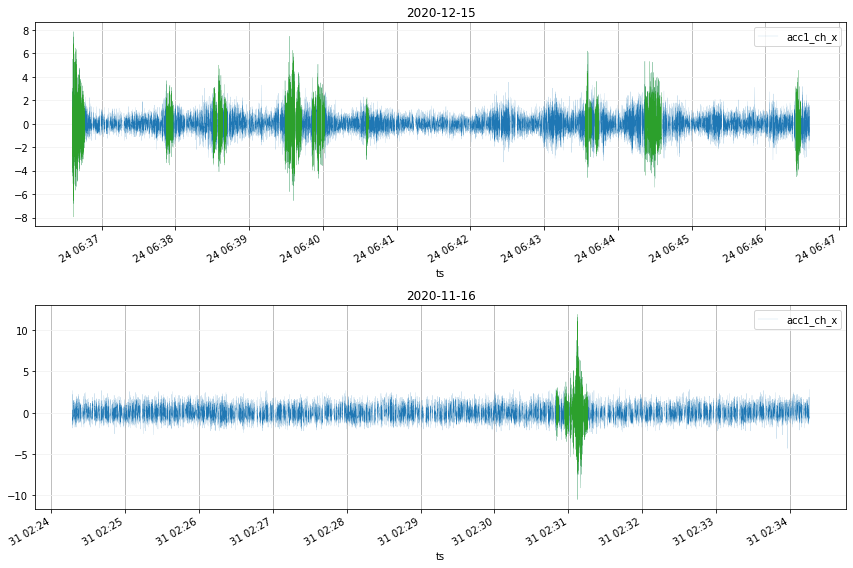

In [39]:
data.plot_filtered_hours_categories(labels = kmeans.send_labels(), predictor = kmeans)

In [43]:
import numpy as np

In [49]:
kmeans.kmeans.predict(np.array([1,1,1,0,0,0,1]).reshape(1,-1))

array([1], dtype=int32)